<span style="font-size:3.5em;">Preparing Data Set</span>

In [6]:
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh
!chmod +x miniconda.sh
!bash miniconda.sh -b -f -p /usr/local
!/usr/local/bin/conda init bash

--2024-04-26 21:46:25--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143351488 (137M) [application/octet-stream]
Saving to: ‘miniconda.sh’

miniconda.sh        100%[===================>] 136.71M   217MB/s    in 0.6s    

2024-04-26 21:46:26 (217 MB/s) - ‘miniconda.sh’ saved [143351488/143351488]

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packa

In [1]:
! pip install torchani
## if using GPU acceleration use run these lines
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
import cuml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 7.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyli

In [2]:
import itertools

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torchani

from sklearn.preprocessing import OneHotEncoder
import pickle
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.10/dist-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/usr/local/lib/python3.10/dist-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [4]:

if torch.cuda.is_available():
    device = torch.cuda.get_device_name(0)
    print(f'Using GPU: {device}')
else:
    print('GPU is not available. Using CPU.')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training device: {device}")

Using GPU: Tesla T4
Training device: cuda


In [5]:
#dataset class needs to encode the library we are creating here
def atom_type(filename):
    all_seq=[]
    with open(filename, 'r') as file:
        for line in file:
            # Skip lines that don't start with an atom identifier
            if line.startswith("CSD_code"):
                continue
            if line[0].isalpha():
                part = line.split()
                atom_identifier = part[0]
                all_seq.append(atom_identifier)
        atom_seq = [[atom] for atom in set(all_seq)]
        #may need to add paadding to the sequence will do that at the end with the class.
        vocab = np.unique(atom_seq)
    indexer = torchani.utils.ChemicalSymbolsToInts(vocab)
    index = indexer(vocab)
    index
    tuples = [(key, value)
              for i, (key, value) in enumerate(zip(vocab, index))]
    atom_dict = dict(tuples)
    return atom_dict, vocab
atom_dict, vocab = atom_type('tmQM_X.xyz')
df = pd.read_csv('tmQM_y.csv', delimiter = ';')
csd_to_target = df.set_index('CSD_code')['Polarizability'].to_dict()

In [ ]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250,
        1.975000, 2.243750, 2.512500, 2.781250,
        3.050000, 3.318750, 3.587500, 3.856250,
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680,
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = len(vocab)
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

32384


In [ ]:
def parse_dataset(file_path):
    # Initialize lists to hold species and coordinates
    species_list = []
    coordinates_list = []

    # Variables to keep track of the largest molecule length
    largest_molecule_length = 0

    with open(file_path, 'r') as file:
        while True:
            # Read the first line to get the number of atoms
            line = file.readline()
            if not line:
                break

            line = line.strip()
            if not line:
                continue  # Skip empty lines

            try:
                # Attempt to convert the line to an integer
                num_atoms = int(line)
            except ValueError:
                print(f"Error converting line '{line}' to an integer. Skipping this line.")
                continue

            # Update the largest molecule length
            largest_molecule_length = max(largest_molecule_length, num_atoms)

            # Initialize lists to hold species and coordinates for the current molecule
            species = []
            coordinates = []

            # Read the molecule description line
            description = file.readline().strip()

            # Read each atom line
            for _ in range(num_atoms):
                atom_line = file.readline().strip()
                parts = atom_line.split()

                # Extract the species and coordinates
                atom_symbol = parts[0]
                x, y, z = map(float, parts[1:4])

                # Convert the atom symbol to its corresponding atomic number (e.g., 'Sc' to 21)
                atomic_index = atom_dict[atom_symbol].item()

                # Append the atomic number and coordinates to the lists
                species.append(atomic_index)
                coordinates.append([x, y, z])

            # Append the species and coordinates of the current molecule to the main lists
            species_list.append(species)
            coordinates_list.append(coordinates)

    return species_list, coordinates_list, largest_molecule_length

# species_list, coordinates_list, largest_molecule_length  = parse_dataset('3tmQM_X.xyz')


In [ ]:
def parse_dataset(file_path, atom_dict, min_length=0):
    # Initialize lists to hold species and coordinates
    species_list = []
    coordinates_list = []
    discarded_csd_codes = []

    # Variables to keep track of the largest molecule length
    largest_molecule_length = 0
    # largest_accepted_molecule_length = 0

    with open(file_path, 'r') as file:
        while True:
            # Read the first line to get the number of atoms
            line = file.readline()
            if not line:
                break

            line = line.strip()
            if not line:
                continue  # Skip empty lines

            try:
                # Attempt to convert the line to an integer
                num_atoms = int(line)
            except ValueError:
                # print(f"Error converting line '{line}' to an integer. Skipping this line.")
                continue



            # Update the largest molecule length
            # largest_molecule_length = max(largest_molecule_length, num_atoms)

            # Read the molecule description line
            description = file.readline().strip()

            # Extract CSD code from the description (assuming it's available in the description line)
            # Adjust this based on your dataset format
            csd_code = description.split('|')[0].split('=')[-1].strip()

             # Check molecule length and filter if necessary
            if num_atoms >= min_length:
                # Store discarded CSD code
                discarded_csd_codes.append(csd_code)
                # Update the largest molecule length
                # largest_molecule_length = max(largest_molecule_length, num_atoms)
                # Skip adding this molecule to the lists
                continue

            # Initialize lists to hold species and coordinates for the current molecule
            species = []
            coordinates = []

            # if num_atoms <= min_length:
              # print(num_atoms)
            # Read each atom line
            for _ in range(num_atoms):
                atom_line = file.readline().strip()
                parts = atom_line.split()

                # Extract the species and coordinates
                atom_symbol = parts[0]
                x, y, z = map(float, parts[1:4])

                # Convert the atom symbol to its corresponding atomic index
                atomic_index = atom_dict.get(atom_symbol, None)
                if atomic_index is None:
                    print(f"Unknown atom type: {atom_symbol}. Skipping this atom.")
                    continue

                # Append the atomic index and coordinates to the lists
                species.append(atomic_index.item())  # Convert to integer
                # print(species)
                coordinates.append([x, y, z])



            # Append the species and coordinates of the current molecule to the main lists
            species_list.append(species)
            coordinates_list.append(coordinates)
            largest_molecule_length = max(largest_molecule_length, len(species))
    # for i in species_list:
    #   largest_molecule_length = max(largest_molecule_length, len(i))
            # largest_accepted_molecule_length = max(largest_accepted_molecule_length, len(species))
    # discarded_csd_codes = list(set(discarded_csd_codes))
    return species_list, coordinates_list, largest_molecule_length, discarded_csd_codes
# species_list, coordinates_list, largest_molecule_length, discarded_csd_codes  = parse_dataset('tmQM_X.xyz', atom_dict, 20)

In [ ]:
def create_tensors(species_list, coordinates_list, largest_molecule_length, batch_size = len(species_list)):
    # Initialize tensors for molecule species and coordinates
    # batch_size = len(species_list)

    # Initialize the tensors with the required shapes
    molecule_species = torch.zeros((batch_size, largest_molecule_length), dtype=torch.long)
    coordinates = torch.zeros((batch_size, largest_molecule_length, 3), dtype=torch.float32)

    # Fill the tensors with data from the lists
    for i in range(batch_size):
        molecule_length = len(species_list[i])

        # Fill the molecule species tensor
        molecule_species[i, :molecule_length] = torch.tensor(species_list[i], dtype=torch.long)

        # Fill the coordinates tensor
        coordinates[i, :molecule_length, :] = torch.tensor(coordinates_list[i], dtype=torch.float32)

    return molecule_species, coordinates
# molecule_species, coordinates = create_tensors(species_list, coordinates_list, largest_molecule_length)

In [ ]:
# print(len(species_list), len(coordinates_list[0]), largest_molecule_length)
# # print(coordinates_list[0][0])
# print(molecule_species.shape, coordinates.shape)
# _, aevs = aev_computer((molecule_species, coordinates)) # most likeley should only be done during the batch process.
# print(aevs.shape)

1739 19 24
torch.Size([1739, 24]) torch.Size([1739, 24, 3])
torch.Size([1739, 24, 32384])


In [ ]:
# df = pd.read_csv('tmQM_y.csv', delimiter = ';')
# csd_to_target = df.set_index('CSD_code')['Polarizability'].to_dict()
# # csd_to_target

In [ ]:
class MolecularData(Dataset):
    def __init__(self, filename, atom_seq, vocab):
        self.filename = filename
        self.coord_dict = {}
        self.atom_dict = {}
        self.atom_seq=atom_seq
        #onehot encoding
        self.vocab = np.array(vocab, dtype=str).reshape(-1, 1)
        self.encoder = OneHotEncoder()
        self.encoder.fit(self.vocab)

        self.features = {}

    def parse_file(self):
        with open(self.filename, 'r') as file:
            csd_code = None
            mnd = None

            for line in file:
                line = line.strip()

                if not line:
                    continue

                if line.startswith("CSD_code"):
                    parts = line.split("|")
                    csd_code = parts[0].split("=")[1].strip()
                    mnd = int(parts[-1].split("=")[1].strip())
                    self.atom_dict[csd_code] = {
                        'one_hot_encoded': [],
                        'coordinates': []
                    }

                if line[0].isalpha():
                    if line.startswith("CSD_code"):
                        continue
                    else:
                        parts = line.split()
                        atom_type = parts[0]
                        # print('atom line:', atom_type)
                        coordinates = list(map(float, parts[1:]))

                        self.atom_dict[csd_code]['one_hot_encoded'].append(self.encoder.transform([[atom_type]]).toarray())
                        self.atom_dict[csd_code]['coordinates'].append(coordinates)


                if csd_code is not None and mnd is not None:
                    self.coord_dict[csd_code] = mnd

    def read_csv(self, csv_filename):
        # Read CSV file into DataFrame
        df = pd.read_csv(csv_filename, delimiter=';')
        for index, row in df.iterrows():
            csd_code = row['CSD_code']
            features = {}
            for column in df.columns:
                if column != 'CSD_code':
                    features[column] = row[column]
            self.features[csd_code] = features

    def __len__(self):
        return len(self.atom_dict)

    def __getitem__(self, idx):
        # Return one-hot encoded atoms and associated coordinates
        csd_code = list(self.atom_dict.keys())[idx]
        atom_seq = torch.tensor(self.atom_dict[csd_code]['one_hot_encoded'])
        coordinates = self.atom_dict[csd_code]['coordinates']
        features = self.features[csd_code]

        atom_features = [features.get(feature, 0) for feature in range(48, 57)]

        # Create one-hot encoding matrix
        one_hot_matrix = torch.cat(atom_seq, dim=0)

        # Create position matrix
        position_matrix = torch.tensor(coordinates, dtype=torch.float).unsqueeze(1)

        # Combine one-hot matrix, position matrix, and atom features
        data = torch.cat((one_hot_matrix, position_matrix, torch.tensor(atom_features)), dim=0)

        return data

In [ ]:
import pdb
class MolecularData(Dataset):
    def __init__(self, filename, atom_seq, vocab):
        self.filename = filename
        self.coord_dict = {}
        self.atom_dict = {}
        self.atom_seq=atom_seq
        #onehot encoding
        self.vocab = np.array(vocab, dtype=str).reshape(-1, 1)
        self.encoder = OneHotEncoder()
        self.encoder.fit(self.vocab)

        self.features = {}



    # def _one_hot_encode(self, atom_seq):
    #     self.atom_seq_encoded = [
    #         torch.tensor(
    #             self.encoder.transform(np.array(a).reshape(-1,1)).toarray(), # transform data
    #             dtype=torch.float
    #         ) for a in self.atom_seq
    #     ]
    #     return self.atom_seq_encoded
    #     # self.X = self.data[:, :-1, :]
    #     # self.y = self.data[:, 1:, :]



    def parse_file(self):
        pass
        #print('atom line:', atom_type)k
    def read_csv(self, csv_filename):
        # Read CSV file into DataFrame
        df = pd.read_csv(csv_filename, delimiter=';')
        for index, row in df.iterrows():
            csd_code = row['CSD_code']
            features = {}
            for column in df.columns:
                if column != 'CSD_code':
                    features[column] = row[column]
            self.features[csd_code] = features
    # def read_csv(self, csv_filename):
    # for index, row in df.iterrows():
            # csd_code = row['CSD_code']
            # self.features[csd_code] = row.to_dict()

            # Add other columns to corresponding attributes


    # def expand_coordinates(self):
    #     # Expand tuples into separate arrays for each atom's coordinates
    #     self.coordinates_x = []
    #     self.coordinates_y = []
    #     self.coordinates_z = []
    #     for coords in self.df['coordinates']:
    #         x, y, z = zip(*coords)
    #         self.coordinates_x.append(list(x))
    #         self.coordinates_y.append(list(y))
    #         self.coordinates_z.append(list(z))

    def __len__(self):
        # return len(self.atom_seq_encoded)
        return len(self.atom_seq)

    def __getitem__(self, idx):
        pdb.set_trace()
        # print(idx)
        # if not self.features:
        #   self.parse_file()

        # Return one-hot encoded atoms and associated coordinates
        at_code = self.atom_seq[idx]
        # print(at_code)
        atom_seq_encoded = self.encoder.transform([[at_code]]).toarray()
        coordinates = [0.0, 0.0, 0.0]  # Placeholder coordinates
        features = self.features[csd_code]

        print("Atom seq shape:", atom_seq.shape)
        print("Coordinates shape:", coordinates.shape)
        print("Features shape:", len(atom_features))


        atom_features = [features.get(feature, 0) for feature in range(0, 9)]
        # print("Shape of one_hot_matrix:", one_hot_matrix.shape)
        atom_features_tensor = torch.tensor(atom_features, dtype=torch.float).unsqueeze(1)

        ## Create one-hot encoding matrix
        one_hot_matrix = torch.tensor(atom_seq_encoded, dtype=torch.float)
        # print("Shape of atom_features tensor:", atom_features_tensor.shape)

        ## Create position matrix
        position_matrix = torch.tensor(coordinates, dtype=torch.float).unsqueeze(1)
        # print("Shape of position_matrix:", position_matrix.shape)

        ## Combine one-hot matrix, position matrix, and atom features
        data = torch.cat((one_hot_matrix, position_matrix, torch.tensor(atom_features)), dim=0)

        return data
        # return atom_seq, coordinates, features
        # return self.atom_seq_encoded[idx], self.coordinates[idx]

In [ ]:
class MolecularData(Dataset):
    def __init__(self, filename):
        self.features = []
        self.targets = []
        # Read CSV file into DataFrame
        df = pd.read_csv(filename, delimiter=',')
        X = df[['X_Position', 'Y_Position', 'Z_Position', 'Metal_q']].values
        self.targets = df[['Polarizability']].values.reshape(-1, 1)
        self.scaler = StandardScaler()
        self.encoder=OneHotEncoder()

        # X_norm = self.scaler.fit_transform(X)
        atom_onehot = self.encoder.fit_transform(df['Atom'].values.reshape(-1, 1)).toarray()

        self.features = np.hstack((X, atom_onehot))
        self.X = self.features
        self.y = self.targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float)
        target = torch.tensor(self.targets[idx], dtype=torch.float)

        return features, target


In [6]:
class MolecularDataset(Dataset):
    def __init__(self, file_path, atom_dict, min_length=100): #removed batch_size=1024
        # Initialize the file path, atom dictionary, minimum length, and batch size
        self.file_path = file_path
        self.atom_dict = atom_dict
        self.min_length = min_length
        # self.batch_size = batch_size
        # self.features = []
        self.targets = []
        self.batch_aevs =[]

        # Parse the dataset and store species and coordinates lists
        self.species_list, self.coordinates_list, self.largest_molecule_length, self.discarded_csd_codes, self.target_list = self.parse_dataset(file_path, atom_dict, min_length)

        # Initialize the AEV computer
        self.aev_computer = self.init_aev_computer()

        # Convert species and coordinates lists to tensors
        self.molecule_species, self.coordinates, self.targets = self.create_tensors(self.species_list, self.coordinates_list, self.largest_molecule_length, self.target_list)

    def parse_dataset(self, file_path, atom_dict, min_length):


        species_list=[]
        coordinates_list=[]
        discarded_csd_codes = []
        target_list = []
        largest_molecule_length = 0
        with open(file_path, 'r') as file:
          while True:
              # Read the first line to get the number of atoms
              line = file.readline()
              if not line:
                  break

              line = line.strip()
              if not line:
                  continue  # Skip empty lines

              try:
                  # Attempt to convert the line to an integer
                  num_atoms = int(line)
              except ValueError:
                  # print(f"Error converting line '{line}' to an integer. Skipping this line.")
                  continue



              # Update the largest molecule length
              # largest_molecule_length = max(largest_molecule_length, num_atoms)

              # Read the molecule description line
              description = file.readline().strip()

              # Extract CSD code from the description (assuming it's available in the description line)
              # Adjust this based on your dataset format
              csd_code = description.split('|')[0].split('=')[-1].strip()

              # Check molecule length and filter if necessary
              if num_atoms >= min_length:
                  # Store discarded CSD code
                  discarded_csd_codes.append(csd_code)
                  # Update the largest molecule length
                  # largest_molecule_length = max(largest_molecule_length, num_atoms)
                  # Skip adding this molecule to the lists
                  continue

              # Initialize lists to hold species and coordinates for the current molecule
              species = []
              coordinates = []


              for _ in range(num_atoms):
                  atom_line = file.readline().strip()
                  parts = atom_line.split()

                  # Extract the species and coordinates
                  atom_symbol = parts[0]
                  x, y, z = map(float, parts[1:4])

                  # Convert the atom symbol to its corresponding atomic index
                  atomic_index = atom_dict.get(atom_symbol, None)
                  if atomic_index is None:
                      print(f"Unknown atom type: {atom_symbol}. Skipping this atom.")
                      continue

                  # Append the atomic index and coordinates to the lists
                  species.append(atomic_index.item())  # Convert to integer
                  # print(species)
                  coordinates.append([x, y, z])



              # Append the species and coordinates of the current molecule to the main lists
              species_list.append(species)
              coordinates_list.append(coordinates)
              largest_molecule_length = max(largest_molecule_length, len(species))

              target_value = csd_to_target.get(csd_code, None)
              if target_value is not None:
                  target_list.append(target_value)
              else:
                  # Handle the case where the target is not found
                  # You can assign a default value or raise an error, depending on your use case
                  pass
        return species_list, coordinates_list, largest_molecule_length, discarded_csd_codes, target_list

    def create_tensors(self, species_list, coordinates_list, largest_molecule_length, target_list):
        molecule_species = torch.full((len(species_list), largest_molecule_length), -1, dtype=torch.long)
        coordinates = torch.full((len(species_list), largest_molecule_length, 3), 0, dtype=torch.float32)
        target = torch.tensor(target_list, dtype=torch.float32)

        for i in range(len(species_list)):
            molecule_length = len(species_list[i])

            # Fill the molecule species tensor
            molecule_species[i, :molecule_length] = torch.tensor(species_list[i], dtype=torch.long)

            # Fill the coordinates tensor
            coordinates[i, :molecule_length, :] = torch.tensor(coordinates_list[i], dtype=torch.float32)
            # Returns tensors for molecule species and coordinates

            # Convert species and coordinates lists to tensors here
        return molecule_species, coordinates, target

    def init_aev_computer(self):
        # Your existing function to initialize the AEV computer
        Rcr = 5.2
        Rca = 3.5
        EtaR = torch.tensor([16], dtype=torch.float32)
        ShfR = torch.tensor([
            0.900000, 1.168750, 1.437500, 1.706250,
            1.975000, 2.243750, 2.512500, 2.781250,
            3.050000, 3.318750, 3.587500, 3.856250,
            4.125000, 4.393750, 4.662500, 4.931250
        ], dtype=torch.float32)

        EtaA = torch.tensor([8], dtype=torch.float32)
        Zeta = torch.tensor([32], dtype=torch.float32)
        ShfA = torch.tensor([
            0.90, 1.55, 2.20, 2.85
        ], dtype=torch.float32)
        ShfZ = torch.tensor([
            0.19634954, 0.58904862, 0.9817477, 1.37444680,
            1.76714590, 2.15984490, 2.5525440, 2.94524300
        ], dtype=torch.float32)

        num_species = len(self.atom_dict)  #atom_dict contains the number of species
        aev_computer = torchani.AEVComputer(
            Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
        )
        return aev_computer

    def __len__(self):
        return len(self.species_list)

    def __getitem__(self, index):

        # Create lists to hold the batch data
        batch_species = self.molecule_species[index].unsqueeze(0)
        batch_coordinates = self.coordinates[index].unsqueeze(0)
        self.targetT = self.targets[index]


        _, self.batch_aevs = self.aev_computer((batch_species, batch_coordinates))
        padding_mask = (batch_species == -1)
        batch_coordinates = batch_coordinates.detach().masked_fill(padding_mask.unsqueeze(-1), float('nan'))
        _, self.batch_aevs = self.aev_computer((batch_species, batch_coordinates))
        # print('went through!')
        return self.batch_aevs, self.targetT

In [7]:
molecular_data = MolecularDataset('tmQM_X.xyz', atom_dict, min_length=20) #, batch_size=86665
train_size = int(0.8 * len(molecular_data))  # 80% for training, 20% for validation
val_size = len(molecular_data) - train_size
train_data, val_data = torch.utils.data.random_split(molecular_data, [train_size, val_size])


In [ ]:
train_loader = DataLoader(molecular_data, batch_size=16, shuffle=True)
train_data.dataset.batch_aevs
print(train_data, val_data)
# for x, y in train_loader:
#   print(y.shape, x.shape)

<torch.utils.data.dataset.Subset object at 0x7a6abd2d94b0> <torch.utils.data.dataset.Subset object at 0x7a6abd2d9a80>


In [18]:
class Trainer:

    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model.to(device)
        # calulate the number of parameters
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        if opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        elif opt_method == "sgdm":
            # Hint: to use SGDM in PyTorch, use torch.optim.SGD and set momentum to a non-zero value
            self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)
        else:
            raise NotImplementedError("This optimization is not supported")

        self.epoch = epoch
        self.batch_size = batch_size


    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        torch.cuda.empty_cache()
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=self.batch_size, shuffle=True)

        train_mse_list, train_mae_list = [], []
        val_mse_list, val_mae_list = [], []
        weights = self.model.state_dict()
        lowest_val_mse = np.inf
        l1_loss = nn.L1Loss()
        l2_loss = nn.MSELoss()
        # loss_func = 0.5 * l1_loss() + 0.5 * l2_loss()
        # loss_func = nn.MSELoss()
        for n in tqdm(range(self.epoch), leave=False):
            # enable train mode
            self.model.train()
            for X_batch, y_batch in train_loader:
                # X_batch=X_batch.squeeze(1)
                # y_batch=y_batch.unsqueeze(1)
                # print("X_batch:",X_batch.shape)
                # print("y_batch:",y_batch.shape)
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = self.model(X_batch)
                # print("y_pred:",y_pred.shape)
                batch_mse =  l1_loss(y_pred, y_batch) +  l2_loss(y_pred, y_batch)
                # batch_mse = loss_func(y_pred, y_batch)
                # batch_mae = mean_absolute_error(y_pred.detach().numpy(), y_batch.detach().numpy())

                self.optimizer.zero_grad()
                batch_mse.backward()
                self.optimizer.step()

            # Clear GPU cache after each batch or each epoch
            torch.cuda.empty_cache()

            # call the evaluate function
            train_mse, train_mae = self.evaluate(train_data)
            train_mse_list.append(train_mse)
            train_mae_list.append(train_mae)

            val_mse, val_mae = self.evaluate(val_data)
            val_mse_list.append(val_mse)
            val_mae_list.append(val_mae)

            if early_stop:
              if val_mse < lowest_val_mse:
                  lowest_val_mse = val_mse
                  weights = self.model.state_dict()

        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_mse_list, label="Train MSE")
            axes[0].plot(x_axis, val_mse_list, label="Validation MSE")
            axes[0].set_title("MSE Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_mae_list, label="Train MAE")
            axes[1].plot(x_axis, val_mae_list, label="Validation MAE")
            axes[1].set_title("MAE Loss")
            axes[1].legend()

        if early_stop:
            self.model.load_state_dict(weights)

        return {
            "train_mse_list": train_mse_list,
            "train_mae_list": train_mae_list,
            "val_mse_list": val_mse_list,
            "val_mae_list": val_mae_list,
        }

    def evaluate(self, data, print_metrics=False):
        # enable evaluation mode epoch_loss, epoch_acc = 0.0, 0.0
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        mse_loss = nn.MSELoss()
        mae_loss = nn.L1Loss()
        mse, mae = 0.0, 0.0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad():
                batch_importance = y_batch.shape[0]/len(data)
                y_pred = self.model(X_batch)
                mse += mse_loss(y_pred, y_batch).item() * self.batch_size
                mae += mae_loss(y_pred, y_batch).item() * self.batch_size
        mse /= len(data)
        mae /= len(data)
        if print_metrics:
          print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

        return mse, mae


In [ ]:
class NN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(32384,10000),
            nn.ReLU(), # relu
            nn.Linear(10000,1000),
            nn.ReLU(), # relu
            nn.Linear(1000, 500),
            nn.ReLU(), # relu
            nn.Linear(500, 100),
            nn.ReLU(), # relu
            nn.Linear(100,1),
             # summation, max/min, average,
            nn.Identity(),
        )
    def forward(self, x):


      x = self.layers(x)
      x = torch.sum(x, dim=2)
      # x, _= torch.min(x, dim=2, keepdim=True)
      x = x.reshape(x.shape[0])

      return x

NN1 - Number of parameters: 324140059


{'train_mse_list': [680.9072511386089,
  687.4465753720259,
  632.347979375102,
  564.4388345836632,
  311.4368118976175,
  283.6237822697975,
  517.1939372061563,
  249.94704039257087,
  272.37889003026334,
  242.24742540114548],
 'train_mae_list': [19.131490453819318,
  20.72289634072482,
  18.84152699435607,
  19.13106590520899,
  12.778037458945331,
  12.18949624798431,
  17.002280924361564,
  11.672382685490426,
  11.442085435165376,
  11.312969861921777],
 'val_mse_list': [1040.6848799099,
  905.7600650748095,
  995.1299610341971,
  907.7951940254524,
  571.8267600024549,
  555.708296506637,
  902.4088605202735,
  516.5834399002747,
  517.0002846502628,
  548.5347981748099],
 'val_mae_list': [24.4385567004864,
  23.308947284405047,
  24.063104130671576,
  22.42307915320763,
  18.052519079355093,
  18.211831371600812,
  22.882394189101,
  16.997064032921426,
  17.226572682307317,
  17.948833465576172]}

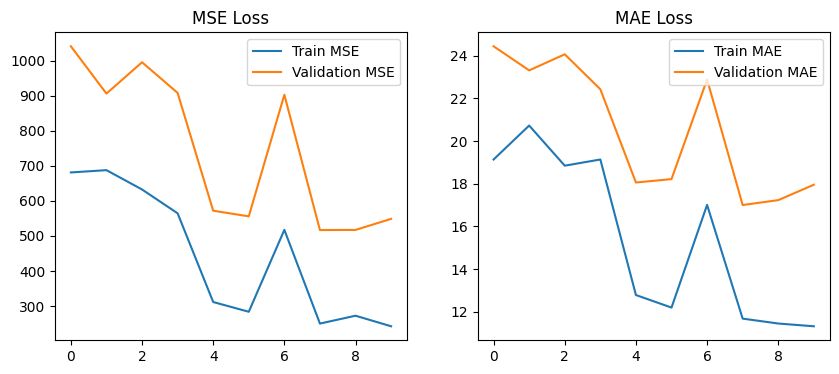

In [ ]:
net=NN1()#this is with min
trainer = Trainer(net, 'adam', 1e-3, 1, 10,0.0)
trainer.train(train_data, val_data)

NN1 - Number of parameters: 324140059


{'train_mse_list': [294.0524134087764,
  198.98266837762952,
  73.95044823651793,
  91.7416551926062,
  87.88867445901639,
  276.0513895837279,
  40.41622383537952,
  47.10543679608246,
  120.67933913637967,
  31.982185071122945],
 'train_mae_list': [12.152712232115642,
  10.853046630388969,
  6.340773749673068,
  7.472460465624153,
  7.688380254256702,
  14.075789060206771,
  4.772729972883456,
  5.159577026073184,
  8.81660459220754,
  4.260516635255318],
 'val_mse_list': [419.8689541387515,
  372.5703883982335,
  155.53403198864814,
  199.190715655183,
  222.41108435960487,
  446.15142727471317,
  143.04062552999417,
  157.64378731298046,
  214.46846647975036,
  149.5159721190271],
 'val_mae_list': [14.807209190955529,
  15.309085552509014,
  8.788035172682543,
  10.906868978647084,
  11.00307405911959,
  16.852047054584208,
  8.011816817063552,
  8.782019277719352,
  10.726387111957257,
  8.347545682466947]}

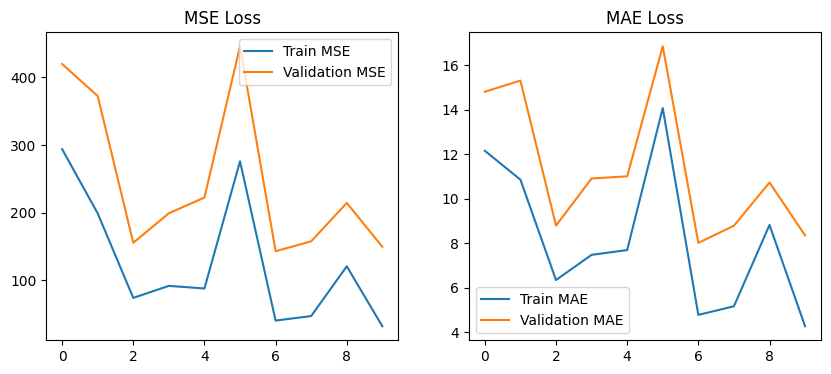

In [ ]:
net=NN1()#this is with average
trainer = Trainer(net, 'adam', 1e-3, 1, 10,0.0)
trainer.train(train_data, val_data)

NN1 - Number of parameters: 324140059


{'train_mse_list': [596.7471865289679,
  570.6950991937038,
  297.91961696122183,
  242.97622012271256,
  126.44052913346147,
  177.23411898621356,
  280.92187786106604,
  104.83792704444913,
  85.2121762112918,
  90.82558007344876],
 'train_mae_list': [17.876717297328,
  17.95062056671907,
  12.693497711064039,
  11.856383770187467,
  8.43747761897269,
  10.163790495179752,
  14.05224855603051,
  7.918279813204197,
  7.158424840497144,
  7.259239409929985],
 'val_mse_list': [898.4485660666456,
  775.017025989466,
  549.2665901532862,
  420.19017234284144,
  395.9400549068545,
  323.10109353532584,
  507.52189510905254,
  289.2752266717072,
  279.3985726991131,
  228.7471895463496],
 'val_mae_list': [23.69629319997934,
  21.599149968073917,
  17.644664177527794,
  15.605890186016376,
  14.21482438307542,
  12.9761472261869,
  17.943199744591347,
  12.354071866548978,
  11.90197008573092,
  11.043790611853966]}

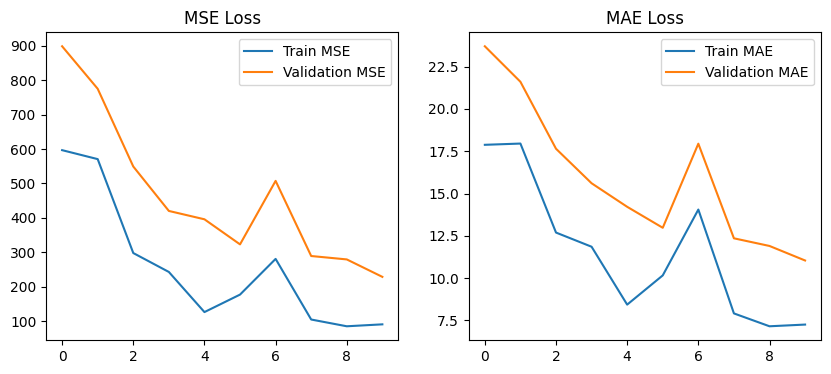

In [ ]:
net=NN1()#this is with max
trainer = Trainer(net, 'adam', 1e-3, 1, 10,0.0)
trainer.train(train_data, val_data)

NN1 - Number of parameters: 324140059


{'train_mse_list': [545.2011091672961,
  116.62088894516567,
  88.46997352502567,
  75.0711668230901,
  74.79193281305744,
  55.62361701722804,
  40.97134360818424,
  47.668948447817634,
  66.75626524243556,
  76.27059000154506],
 'train_mae_list': [19.859479510944933,
  7.98399107534302,
  6.738634223423482,
  6.501300010607651,
  6.812814106141901,
  5.564908867396831,
  4.812471871201473,
  5.308269059726958,
  6.090535261268101,
  6.909807319126607],
 'val_mse_list': [488.3107487109991,
  232.61096530608438,
  190.91423313268103,
  181.44221728976387,
  193.2166773583722,
  167.08591001343268,
  132.69961636802898,
  188.6004050932108,
  199.31328195890126,
  206.24744904574294],
 'val_mae_list': [18.262396416297324,
  10.669085223858174,
  9.283940359262319,
  9.55603989821214,
  10.27464118370643,
  9.379475637582631,
  7.548238255427434,
  9.181443493182842,
  9.686238919771634,
  10.124989905724158]}

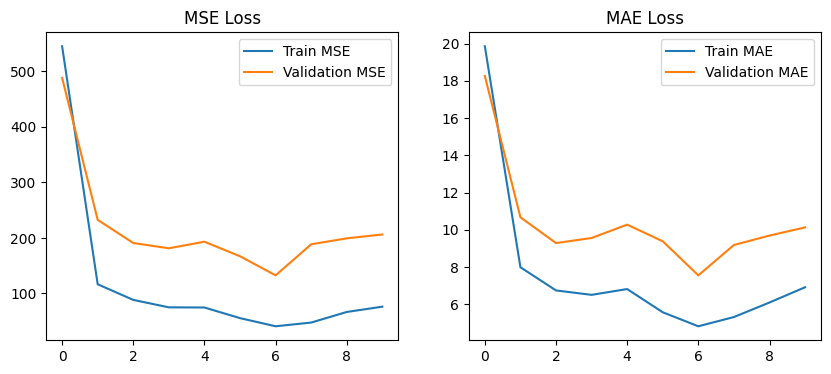

In [ ]:
net=NN1()#this is with summation 2 hidden layers (32384, 10000 ) (10000, 29) (29,1)
trainer = Trainer(net, 'adam', 1e-3, 1, 10,0.0)
trainer.train(train_data, val_data)

In [ ]:
torch.cuda.empty_cache()
net=NN1()#this is with summation and more layers
trainer = Trainer(net, 'adam', 1e-3, 1, 10,0.0)
trainer.train(train_data, val_data)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.21 GiB. GPU 0 has a total capacity of 14.75 GiB of which 87.06 MiB is free. Process 8770 has 14.66 GiB memory in use. Of the allocated memory 13.63 GiB is allocated by PyTorch, and 924.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
class NN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(48, 250),
            nn.BatchNorm1d(250),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.BatchNorm1d(500),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.BatchNorm1d(250),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(250, 100),
            nn.BatchNorm1d(100),   # Add batch normalization
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Identity(),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


In [ ]:
net=NN2()
trainer = Trainer(net, 'adam', 1e-3, 1000, 10,0.0)
trainer.train(train_data, val_data)

In [ ]:
class NN3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(NN3, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # Define the first layer with batch normalization
        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_size)])
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_size)])

        # Define the hidden layers with batch normalization
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.batch_norms.append(nn.BatchNorm1d(hidden_size))

        # Define the output layer
        self.layers.append(nn.Linear(hidden_size, output_size))

        # Activation function
        self.activation = nn.ReLU()

    def forward(self, x):
        for layer, batch_norm in zip(self.layers[:-1], self.batch_norms):
            x = self.activation(batch_norm(layer(x)))
        # Output layer without activation
        x = self.layers[-1](x)
        return x


In [ ]:
# net=NN()
net = NN3(48, 100, 1, 25)
# model, opt_method, learning_rate, batch_size, epoch, l2
trainer = Trainer(net, 'adam', 1e-3, 1000, 10,0.0)
# trainer = Trainer(net, 'adam', 1e-1, 1000, 10,0.0)
# train_data, val_data
trainer.train(train_data, val_data)

NN3 - Number of parameters: 8911501


KeyboardInterrupt: 

NN2 - Number of parameters: 1059901


{'train_mse_list': [175388.60573039867,
  170411.1872944672,
  160766.20306099637,
  151454.46073782668,
  143198.0714172388,
  127808.6547112084,
  101097.31887872843,
  97115.18727373362,
  89731.41640945018,
  67848.49280454913,
  58969.811806777536,
  50907.10345691744,
  50851.775751546906,
  35086.313239647636,
  28354.272372200066,
  19585.773744221642,
  15201.100631517553,
  14359.764768613339,
  10452.53705111817,
  7150.562529128415,
  4689.136804219643,
  2839.320406899727,
  2164.795096180673,
  1887.1098338288732,
  1549.9673111718118,
  1159.1279151937192,
  1035.6894977120392,
  812.221425201217,
  798.9515747922474,
  754.9517213428232,
  718.8517434539381,
  792.2247323960707,
  777.3702506246552,
  754.0195187563328,
  732.8519108648536,
  687.2818837402147,
  737.8829941089049,
  772.5119747293255,
  712.1603317670097,
  734.738991621327,
  690.1613157454237,
  686.4315854528528,
  711.9733634028344,
  692.8105867927599,
  685.9165870166036,
  679.0787374361879,
  7

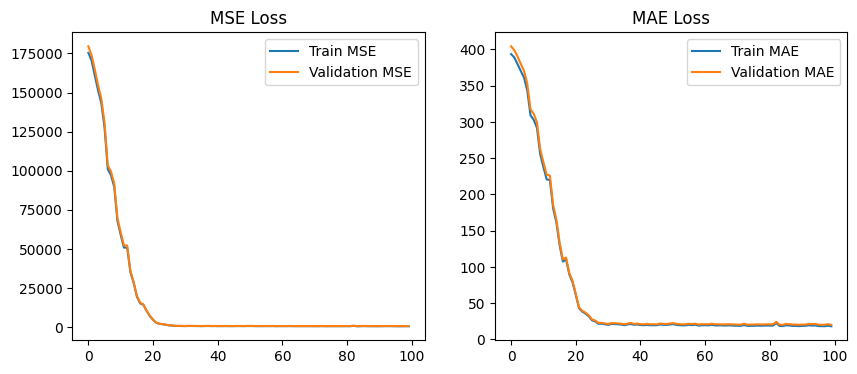

In [ ]:
# net=NN2()
# # net = NN3(7, 300, 1, 100)
# # model, opt_method, learning_rate, batch_size, epoch, l2
# trainer = Trainer(net, 'adam', 1e-3, 1000, 100,0.0)
# # trainer = Trainer(net, 'adam', 1e-1, 1000, 10,0.0)
# # train_data, val_data
# trainer.train(train_data, val_data)

<span style="font-size:3.5em;">VAE Method</span>

In [ ]:
def kld_loss_func(mu, sigma):
    return 0.5 * torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) -1)


def vae_loss_func(recon_x, x, mu, sigma):
    # print("recon_x, x",recon_x, x)
    mse_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    kld_loss = kld_loss_func(mu, sigma)
    # print(type(kld_loss), type(bce_loss))
    return mse_loss + kld_loss

In [ ]:
#class VAETrainer:

    def __init__(self, model, learning_rate, batch_size, epoch, l2):
        self.model = model
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)

        self.epoch = epoch
        self.batch_size = batch_size



    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)

        train_loss_list = []
        val_loss_list = []

        weights = self.model.state_dict()
        lowest_val_loss = np.inf

        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = 1 / len(train_data)
                # call the model
                X_batch_recon, mu, sigma = self.model(X_batch) #forward pass
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma) #

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                epoch_loss += batch_loss.detach().cpu().item() * batch_importance

            train_loss_list.append(epoch_loss)

            val_loss = self.evaluate(val_data, print_loss=False)
            val_loss_list.append(val_loss)

            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(x_axis, train_loss_list, label="Train")
            ax.plot(x_axis, val_loss_list, label="Validation")
            ax.set_title("Total Loss")
            ax.set_xlabel("# Epoch")

        if early_stop:
            self.model.load_state_dict(weights)

        return {
            "train_loss_list": train_loss_list,
            "val_loss_list": val_loss_list,
        }

    def evaluate(self, data, print_loss=True):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size)
        total_loss = 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = 1 / len(data)
                X_batch_recon, mu, sigma = self.model(X_batch) #foward pass
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma)
                total_loss += batch_loss.detach().cpu().item() * batch_importance
        if print_loss:
            print(f"Total Loss: {total_loss}")
        return total_loss

In [ ]:
class VAEregressTrainer:

    def __init__(self, model, learning_rate, batch_size, epochs, l2, regression_loss_func):
        self.model = model
        self.regression_loss_func = regression_loss_func  # Loss function for the regression task
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)

        self.epochs = epochs
        self.batch_size = batch_size

    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)

        train_total_loss_list = []
        train_regression_loss_list = []
        val_total_loss_list = []
        val_regression_loss_list = []

        # Initialize weights for early stopping
        weights = self.model.state_dict()
        lowest_val_loss = np.inf

        for epoch in tqdm(range(self.epochs), leave=False):
            self.model.train()
            epoch_total_loss = 0.0
            epoch_regression_loss = 0.0

            for X_batch, y_batch in train_loader:
                batch_importance = 1 / len(train_data)

                # Forward pass
                X_batch_recon, mu, logvar, regression_pred = self.model(X_batch)

                # Calculate VAE loss
                vae_loss = vae_loss_func(X_batch_recon, X_batch, mu, logvar)

                # Calculate regression loss
                regression_loss = self.regression_loss_func(regression_pred, y_batch)

                # Combine the losses
                total_loss = vae_loss + regression_loss

                # Backpropagation and optimization
                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()

                # Accumulate the losses
                epoch_total_loss += total_loss.detach().cpu().item() * batch_importance
                epoch_regression_loss += regression_loss.detach().cpu().item() * batch_importance

            train_total_loss_list.append(epoch_total_loss)
            train_regression_loss_list.append(epoch_regression_loss)

            # Evaluate on validation data
            val_total_loss, val_regression_loss = self.evaluate(val_data)
            val_total_loss_list.append(val_total_loss)
            val_regression_loss_list.append(val_regression_loss)

            # Early stopping condition
            if early_stop and val_total_loss < lowest_val_loss:
                lowest_val_loss = val_total_loss
                weights = self.model.state_dict()

        # Draw loss curves
        if draw_curve:
            x_axis = np.arange(self.epochs)
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            ax.plot(x_axis, train_total_loss_list, label="Train Total Loss")
            ax.plot(x_axis, train_regression_loss_list, label="Train Regression Loss")
            ax.plot(x_axis, val_total_loss_list, label="Validation Total Loss")
            ax.plot(x_axis, val_regression_loss_list, label="Validation Regression Loss")
            ax.set_title("Loss Curves")
            ax.set_xlabel("# Epoch")
            ax.legend()

        # Load the best model if early stopping
        if early_stop:
            self.model.load_state_dict(weights)

        return {
            "train_total_loss_list": train_total_loss_list,
            "train_regression_loss_list": train_regression_loss_list,
            "val_total_loss_list": val_total_loss_list,
            "val_regression_loss_list": val_regression_loss_list,
        }

    def evaluate(self, data):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size)
        total_loss = 0.0
        regression_loss = 0.0

        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = 1 / len(data)

                # Forward pass
                X_batch_recon, mu, logvar, regression_pred = self.model(X_batch)

                # Calculate VAE loss
                vae_loss = vae_loss_func(X_batch_recon, X_batch, mu, logvar)

                # Calculate regression loss
                regression_loss_batch = self.regression_loss_func(regression_pred, y_batch)

                # Combine the losses
                total_loss += (vae_loss + regression_loss_batch).detach().cpu().item() * batch_importance
                regression_loss += regression_loss_batch.detach().cpu().item() * batch_importance

        print(f"Total Loss: {total_loss}, Regression Loss: {regression_loss}")
        return total_loss, regression_loss


In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential( #same model as best performing NN, NN2
            nn.Linear(7, 500),
            nn.BatchNorm1d(500),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.BatchNorm1d(1000),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.BatchNorm1d(500),  # Add batch normalization
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),   # Add batch normalization
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.Identity(),
        )



        # Readout layer is mu
        self.readout_mu = nn.Linear(10, 5) #check
        # Readout layer
        self.readout_sigma = nn.Linear(10, 5) #check

        # You can use nn.ConvTranspose2d to decode
        self.decoder = nn.Sequential(
            nn.Linear(5, 10),               # Reverse of the last linear layer in encoder
            nn.Linear(10,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 500),             # Reverse of the second last linear layer in encoder
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 1000),            # Reverse of the third last linear layer in encoder
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, 500),            # Reverse of the fourth last linear layer in encoder
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 7),               # Reverse of the first linear layer in encoder
            nn.BatchNorm1d(7),
            nn.ReLU(),
        )

    def reparameterize(self, mu, sigma):
        """
        Reparameterize, i.e. generate a z ~ N(\mu, \sigma)
        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + torch.mul(eps,std)
        return z

    def encode(self, x):
        # call the encoder to map input to a hidden state vector
        h = self.encoder(x)
        # print(h)
        # use the "readout" layer to get \mu and \sigma
        mu = self.readout_mu(h)
        sigma = self.readout_sigma(h)
        return mu, sigma

    def decode(self, z):
        # call the decoder to map z back to x
        return self.decoder(z)

    def forward(self, x):
        mu, sigma = self.encode(x)
        z = self.reparameterize(mu, sigma)
        x_recon = self.decode(z)
        # print("this is sig",sigma)
        return x_recon, mu, sigma

NameError: name 'nn' is not defined

In [ ]:
class regression(nn.Module):
  def __init__(self):
    self.linear = nn.Linear(5, 1)

  def forward(self, z):
    return self.linear(z)


class VAERegression(nn.Module):
    def __init__(self, vae, regression_model):
        super(VAERegression, self).__init__()
        self.vae = vae
        self.regression_model = regression_model

    def forward(self, x):
        # Forward pass through VAE
        x_recon, mu, sigma = self.vae(x)
        # Use latent space representation for regression
        z = self.vae.reparameterize(mu, sigma)
        regression_output = self.regression_model(z)
        return x_recon, mu, sigma, regression_output


NameError: name 'nn' is not defined

Further, train the model on another set of data that just focuses on outputting polarizability. tanh activation function. another residual neural network keeping the weights of the former. freeze the weights, done in the training.

Use Kfold cross validation method for training. and early stop method to prevent variance/over fitting. Save the weights and the model and pass through new class. may need to do some edits to make sure that I am approprately adding the lala on to the layer

<span style="font-size:3.5em;">Random Forest Method</span>

In [8]:
def loaddata(data):

  all_features = []
  all_targets = []

  # Iterate over the dataset
  for idx in range(len(data.dataset)):
      # Retrieve features and target for the current index
      features, target = data.dataset[idx]

      # Append the features and target to the lists
      all_features.append(features)
      all_targets.append(target.unsqueeze(0))

  # Convert lists to numpy arrays or tensors as needed
  all_features = torch.cat(all_features, dim=0)
  all_targets = torch.cat(all_targets)
  return all_features, all_targets


# print(all_features.shape)
# print(all_targets.shape)

In [10]:

# from sklearn.ensemble import RandomForestRegressor
from cuml.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA

rf = RandomForestRegressor(n_estimators = 110 ,random_state=0, n_streams=1)
# targets_flattened = train_data.dataset.targets.ravel()
# val_targets_flattened = val_data.dataset.targets.ravel()

features, targets = loaddata(train_data)
flattened_features = features.view(features.size(0), -1)

val_feat, _ = loaddata(val_data)
flattened_val_feat = val_feat.view(val_feat.size(0), -1)
# print(features)
# features = torch.tensor(features).reshape(-1, torch.tensor(features).shape[-1])
# targets = torch.tensor(targets).reshape(-1)
# val_feat= val_data.dataset.batch_aevs
# val_feat = torch.tensor(val_feat).reshape(-1, torch.tensor(val_feat).shape[-1])


# pca = PCA(n_components=3)
# pca_features = pca.fit_transform(flattened_features)
# pca_val_feat = pca.fit_transform(flattened_val_feat)


rf.fit(flattened_features, targets)
y_pred = rf.predict(flattened_val_feat)
val_mse = mean_squared_error(targets, y_pred)

# tree_number = 1
# print("Mean Squared Error:", val_mse)
# plt.figure(figsize=(20, 10))
# plot_tree(rf.estimators_[tree_number], feature_names=[f'Feature {i}' for i in range(flattened_features.shape[1])], filled=True)
# plt.show()

TypeError: Cannot interpret 'torch.float32' as a data type

Mean Squared Error: 260.51617254878454


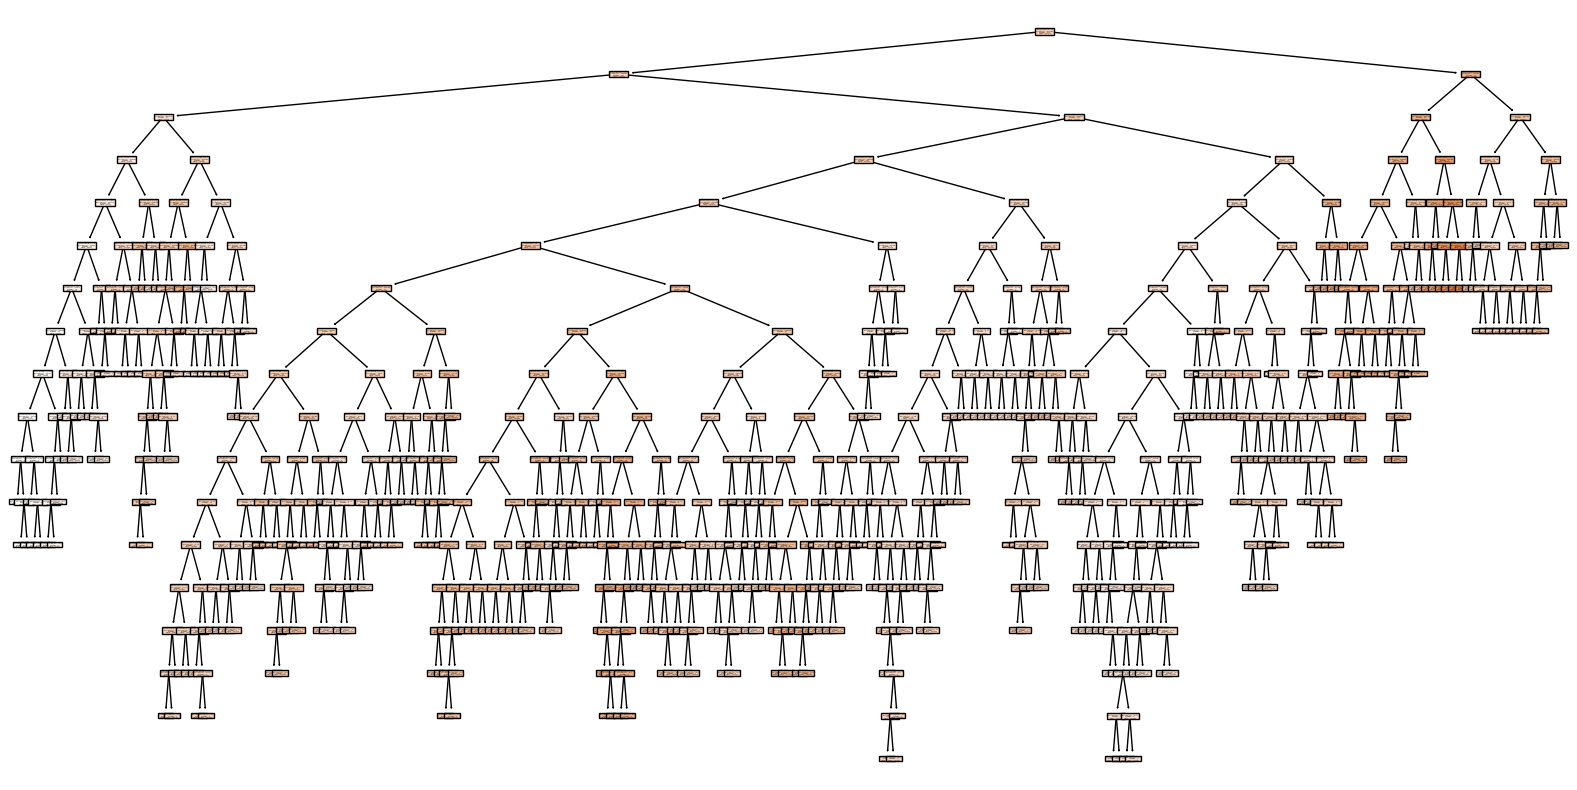

In [29]:
#50_n estimators flattened array
tree_number = 0
print("Mean Squared Error:", val_mse)
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[tree_number], feature_names=[f'Feature {i}' for i in range(flattened_features.shape[1])], filled=True)
plt.show()

Mean Squared Error: 113.93773200245133


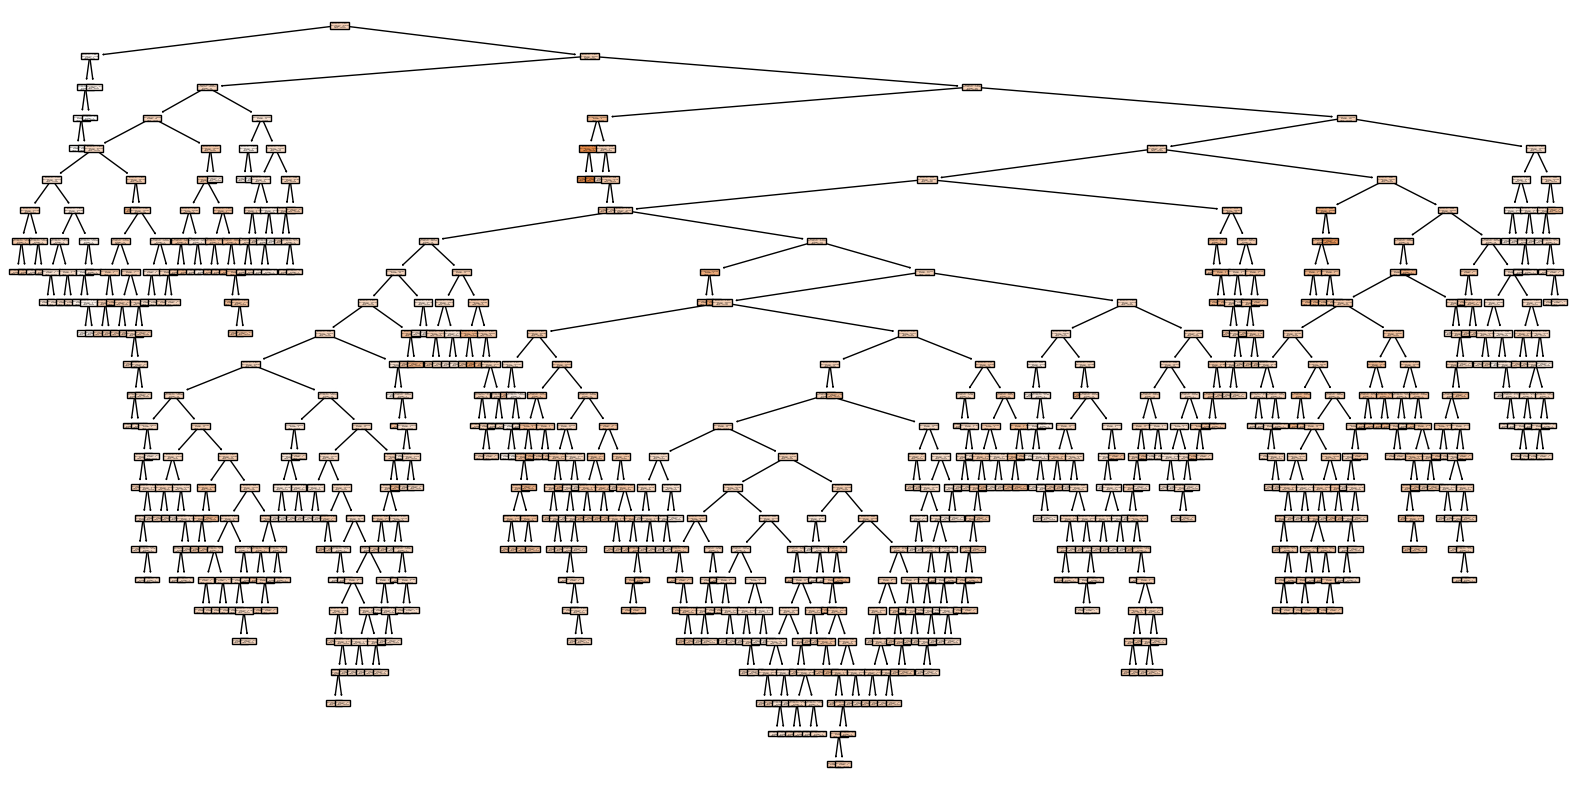

In [10]:
#100 n_estimators PCA 3 components flattened array
tree_number = 1
print("Mean Squared Error:", val_mse)
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[tree_number], feature_names=[f'Feature {i}' for i in range(pca_features.shape[1])], filled=True)
plt.show()

Mean Squared Error: 159.06158126969967


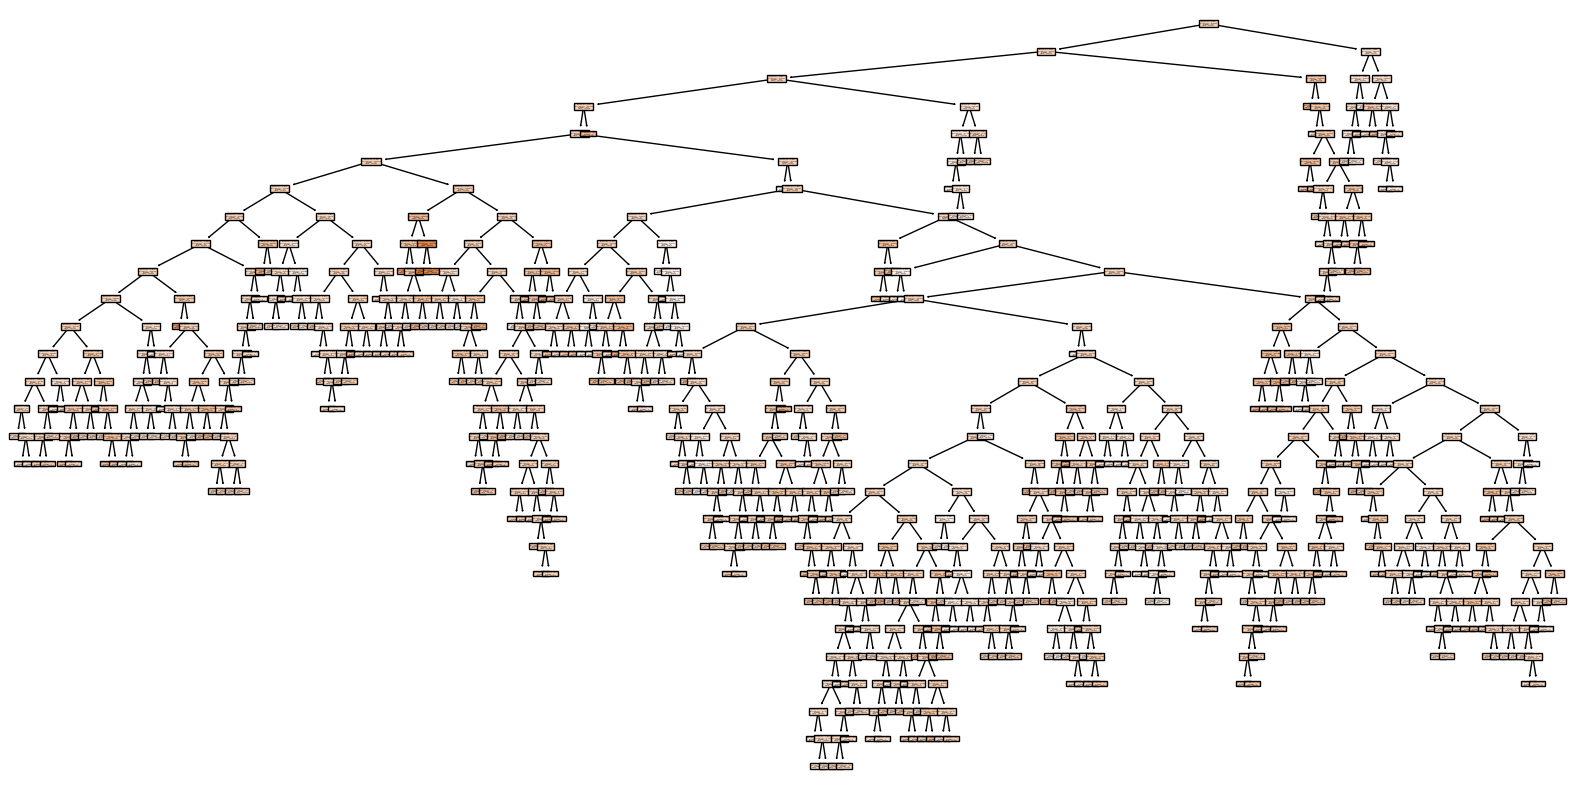

In [16]:
#100 n_estimators PCA 1 component flattened array
tree_number = 1
print("Mean Squared Error:", val_mse)
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[tree_number], feature_names=[f'Feature {i}' for i in range(pca_features.shape[1])], filled=True)
plt.show()

Mean Squared Error: 41.929489281516915


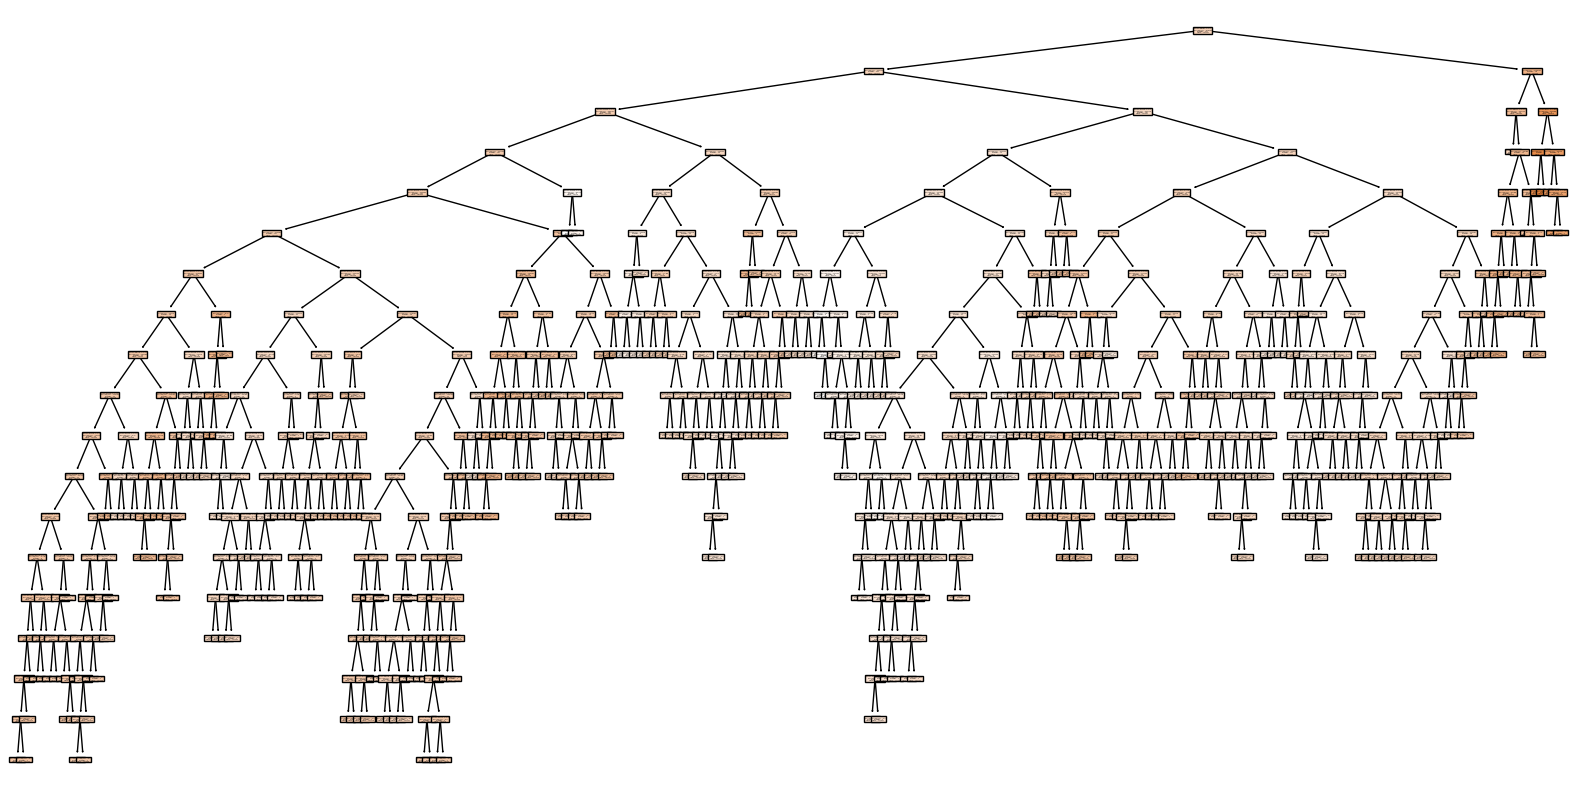

In [14]:
#100_n estimators flattened array
tree_number = 1
print("Mean Squared Error:", train_mse)
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[tree_number], feature_names=[f'Feature {i}' for i in range(flattened_features.shape[1])], filled=True)
plt.show()

In [ ]:
len(np.unique(gg))

3834